<h1>Image Classifier to analises cell viability</h1>

Esse notebook tem o intuito de demonstrar como clusterizar imagens fotografadas por microscópio, identificar microambientes de culturas de células, para quantificar quantas células mortas foram detectadas pelo teste de viabilidade celular, em cada microambiente.

Só vamos usar aqui uma imagem, para fim didático, para execultar o código que processa todas as imagens do conjunto de dados, acesse o arquivo main.py, na raiz desse diretório. Instruções de como executar o código se encontra no arquivo README.md

Um artigo usado como base na aplicação da segmentação de imagem, com KMeans é o "Image Segmentation using K-means Clustering Algorithm and Subtractive Clustering Algorithm" pode ser encontrado clicando [aqui](https://www.researchgate.net/publication/283185016_Image_Segmentation_Using_K_-means_Clustering_Algorithm_and_Subtractive_Clustering_Algorithm):


Esse projeto foi desenvolvido como trabalho de conclusão do Nanodegree Engenheiro de machine learning da Udacity.

In [1]:
import numpy as np
import cv2
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
path = './imgs/'
# dapi - Celulas sem marcação, gfp - Ceulas marcadas como morta e união das duas
img_name = np.array(['20170809_3D LD DAY 5_Area1_#_DAPI.tif', '20170809_3D LD DAY 5_Area1_#_GFP.tif', '20170809_3D LD DAY 5_Area1_#.tif'])

def get_image_dir(index):
    
    r = []
    for item in img_name:
        r.append(path + item.replace('#', str(index)))
    return r
        

<h2>Conjunto de dados</h2>

Nossos dados são recortes de uma amostra de microambientes de células. São 189 imagens, agrupadas em 3 tipos:
Imagens com o sufixo DAPI é uma area sem nenhum detalhe, somente uma fotografia da área;
Imagens com o sufixo GFP é a área em que a imagem só realça o reagente que indica as células mortas;
Imagens sem os sufixos, é a junção das duas anteriores.

Abaixo segue, como exemplo, o grupo de imagens da area 9.

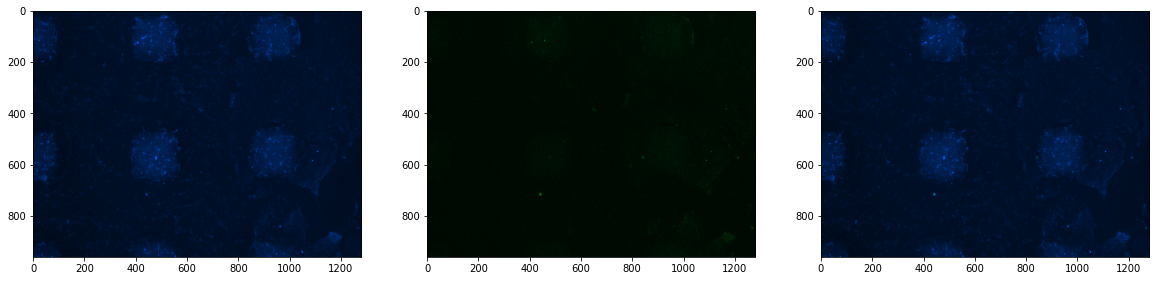

In [3]:
def plot3images(images, labels=[]):
    fig = plt.figure()
    fig.set_size_inches((20,10))
    for i, image in enumerate(images):
        plt.subplot(1, 3, i+1)
        if(len(labels) > 0):
            plt.title(labels[i])
        plt.imshow(image,'gray')
    plt.show()
    
def plt1image(image, size):
    fig = plt.figure()
    fig.set_size_inches(size)
    plt.imshow(image, 'gray')

def load_images(index):    
    dirs = get_image_dir(index)
    images = []
    for i, src in enumerate(dirs):
        images.append(cv2.cvtColor(cv2.imread(src), cv2.COLOR_BGR2RGB))
    return images
    
plot3images(load_images(9))

<h2> Redimensionar imagem </h2>

É sabido que ao trabalhar com imagem, recomenda-se reduzir a dimensão para ganhar em processamento. Porém, ainda não sei qual o efeito disso nesse caso, onde o objetivo é encontrar as células, alvos muito pequenos.
Partindo dessa dúvida vou trabalhar com a imagem normal e redimensionadas em 50% e 25%.

In [4]:
originals = load_images(50)
reduced_50 = []
reduced_25 = []

for i, image in enumerate(originals):
    width = int(image.shape[0] * 0.5)    
    height = int((width / image.shape[1]) * image.shape[0])
    r = cv2.resize(image, (width, height), interpolation=cv2.INTER_AREA)
    reduced_50.append(r)
    width = int(image.shape[0] * 0.25)    
    height = int((width / image.shape[1]) * image.shape[0])
    r = cv2.resize(image, (width, height), interpolation=cv2.INTER_AREA)
    reduced_25.append(r)

<h2> Detectar Microambientes </h2>

Para detectar os microambientes vamos usar KMeans. Nos códigos abaixo foi implementado o metódo de classificação da biblioteca sklearn com alguns aprimoramentos propostos no artigo base.

A métrica usada para avaliar o desempenho do algoritmo é a quantidade de células mortas reconhecidas corretamente e o tempo de execução para cada grupo de imagem original, reduzida em 50% e 25%.

<h3>Contrast Enhancement Using Partial Contrast Stretching</h3>

Imagens de microscópio podem ter problemas, como, baixo contraste e borrões. Para isso iremos implementar uma técnica de aprimoramento sugerida pelo artigo chamada "Partial Contrast Stretching" (PCS). Essa técnica é baseada em uma função de mapeamento linear que é usado para aumentar os níveis de contraste e brilho da imagem.


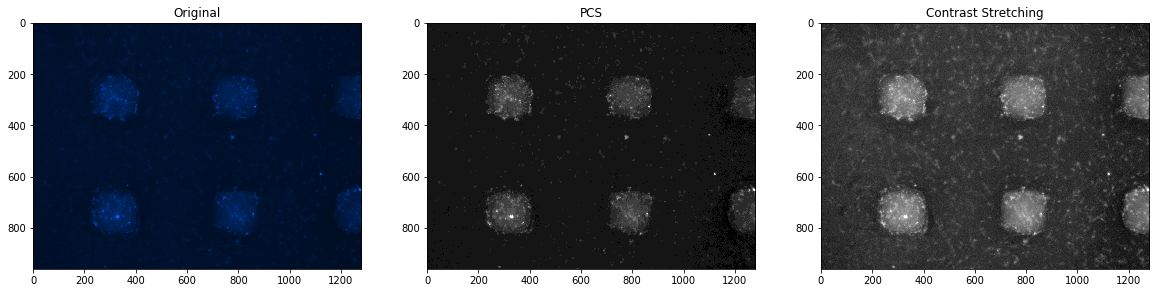

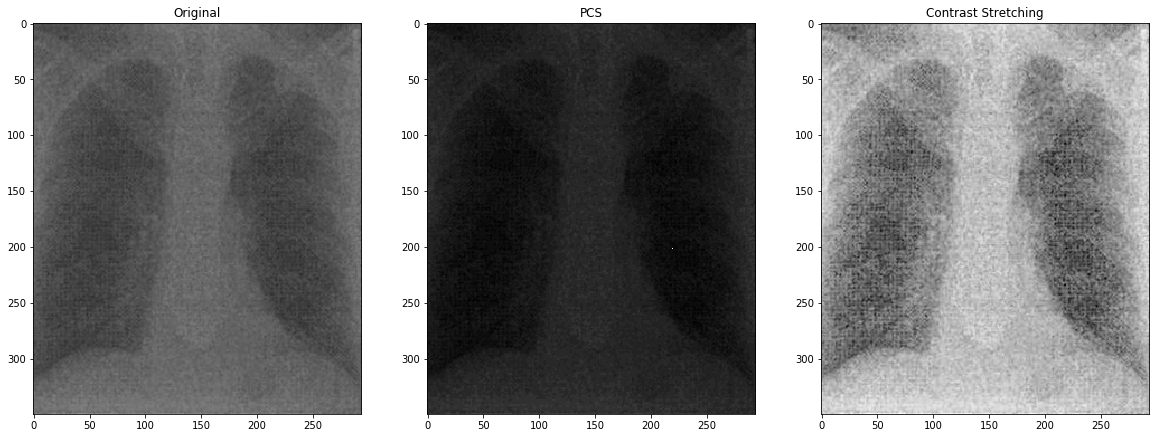

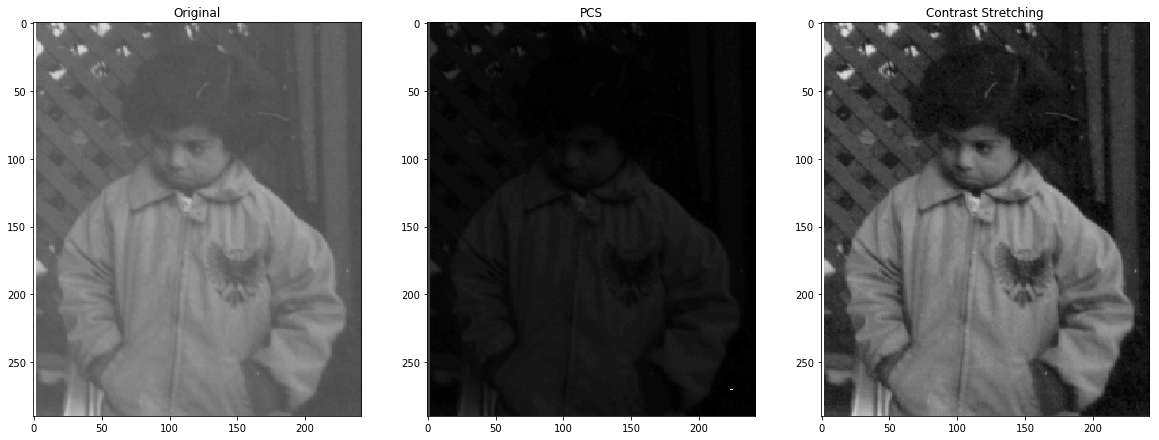

In [5]:
def contrast_stretching(img, E):
    '''
    source: http://www.cs.uregina.ca/Links/class-info/425/Lab3/
    
    Contrast-stretching transformations increase the contrast between the darks and the lights.
    E controls the slope of the function and M is the mid-line where you want 
    to switch from dark values to light values, we use the the mean of the image intensities.
    np.spacing(1) is aconstant that is the distance between 1.0 and the next largest number 
    that can be represented in double-precision floating point.
    
    '''

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _mean = img.reshape((img.shape[0]*img.shape[1], 1)).mean(axis=0)
    M = _mean
    cs = 1 / ( 1 + (M / (img + np.spacing(1))) ** E)
    return np.float32(cs)

def pcs(img, tx = 0.1):
    '''
    source: http://interscience.in/IJPPT_Vol2Iss1/29-34.pdf
    
    Partial  contrast  is  an  auto  scaling  method.  It  is  a  
    linear   mapping   function   that   is   usually   used   to   
    increase the contrast level and brightness level of the 
    image.  This  technique  will  be  based  on  the  original  
    brightness  and  contrast  level  of  the  images  to  do  the  
    adjustment.  
    
    r_max,  b_max  and  g_max  are  the  maximum  
    color level for each red, blue and green color palettes, 
    respectively. r_min, b_min and g_min are the 
    minimum  value  for  each  color  palette,  respectively.  
    maxTH  and  minTH  are  the  average  number  of  these  
    maximum  and  minimum  color  levels  for  each  color  
    space. 
    
    '''
    r, g, b = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    r_min = r.reshape((r.shape[0]*r.shape[1], 1)).min(axis=0)
    g_min = g.reshape((g.shape[0]*g.shape[1], 1)).min(axis=0)
    b_min = b.reshape((b.shape[0]*b.shape[1], 1)).min(axis=0)
    r_max = r.reshape((r.shape[0]*r.shape[1], 1)).max(axis=0)
    g_max = g.reshape((g.shape[0]*g.shape[1], 1)).max(axis=0)
    b_max = b.reshape((b.shape[0]*b.shape[1], 1)).max(axis=0)
    minTH = (r_min + g_min + b_min)/3
    maxTH = (r_max + g_max + b_max)/3
    NminTH = minTH - minTH * tx
    NminTH = 0 if NminTH < 0 else NminTH
    NmaxTH = maxTH + (255 - maxTH) * tx
    NmaxTH = 255 if NmaxTH > 255 else NmaxTH
    
    #print('minTH {}, Nmin {}, maxTH {}, Nmax {}'.format(minTH, NminTH, maxTH, NmaxTH))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
    _min = img.reshape((img.shape[0]*img.shape[1], 1)).min(axis=0)
    output = np.zeros_like(img)
    
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            
            if img[x, y] > minTH :
                output[x,y] = (img[x,y]/minTH) * NminTH
            elif minTH <= img[x, y] and img[x, y] <= maxTH :
                output[x,y] = (((NmaxTH - NminTH)/(maxTH - minTH)) * (img[x,y] - _min)) + _min
            elif img[x, y] < maxTH :
                output[x,y] = (img[x,y]/maxTH) * maxTH
                
    return output

def compare_improvement(img):
    fig = plt.figure()
    fig.set_size_inches((20,20))
    plt.subplot(1,3,1)
    plt.title('Original')
    plt.imshow(img, 'gray')

    plt.subplot(1,3,2)
    img_pcs = pcs(img, 0.9)
    plt.title('PCS')
    plt.imshow(img_pcs, 'gray')

    plt.subplot(1,3,3)
    img_cs = contrast_stretching(img, 0.1)
    plt.title('Contrast Stretching')
    plt.imshow(img_cs, 'gray')
    

img = originals[0]
#img = reduced_50[0]
#img = reduced_25[0]

#img = cv2.imread('./content/girl.png')
#img = cv2.imread('./content/bones.png')

compare_improvement(img)
compare_improvement(cv2.imread('./content/bones.png'))
compare_improvement(cv2.imread('./content/girl.png'))



<h2>Comparando pré-processamentos</h2>

Como é possivel notar, pelas imagens acima, o método "contrast_stretching" se mostrou mais eficiente para melhorar o contraste de imagens em escala de cinza, enquanto para imagens coloridas o PCS se mostrou mais eficaz. Por isso iremos o PCS daqui por diante.

Abaixo temos o comparativo entre o KMeans aplicado em 3 situações:

1 - na imagem processada pelo "PCS" apenas.


2 - na imagem processada pelo "PCS" e depois submetida a um método de limiarização seguido de um medianblur.


3 - na imagem processada pelo "PCS" e depois submetida ao método "log_transformation", seguido de um medianblur.


Ambas as sugestõs foram usadas antes de aplicar o KMeans em diferentes fontes, para segmentar imagens. Meu objetivo é comparar e identificar o que segmenta a imagem em menor tempo.

In [6]:
def log_transformation(constant, image):
    '''
    source: https://medium.com/@sonu008/image-enhancement-contrast-stretching-using-opencv-python-6ad61f6f171c
    
    Can be used to brighten the intensities of an image (like the Gamma Transformation, where gamma < 1).
    More often, it is used to increase the detail (or contrast) of lower intensity values.
    '''
    
    return constant * (np.log(1 + np.float32(image)))


def kmeans(image):
    shape_2 = 1 if len(image.shape) == 2 else image.shape[2]
    reshaped = image.reshape(image.shape[0] * image.shape[1], shape_2)
    kmeans = KMeans(n_clusters=2, n_init=40, max_iter=500).fit(reshaped)
    clustering = np.reshape(np.array(kmeans.labels_, dtype=np.uint8), (image.shape[0], image.shape[1]))
    
    k = 0
    all_black = True
    for i in range(len(clustering)):
        if clustering[i][0] == 1:
            all_black = False
            break
    
    if(not all_black):
        ret,thresh2 = cv2.threshold(clustering,127,255,cv2.THRESH_BINARY_INV)
        clustering = thresh2
    
    return clustering
    



In [7]:
def compare_methods(image):
    '''
    source: https://docs.opencv.org/3.4.0/d7/d4d/tutorial_py_thresholding.html and 
    https://medium.com/@sonu008/image-enhancement-contrast-stretching-using-opencv-python-6ad61f6f171c
    
    
    '''

    import datetime as dt
    
    ini = dt.datetime.now()    
    #blur = cv2.medianBlur(image,5)
    kmeans_1 =  kmeans(image)
    
    print('Tempo de execução kmeans_1 {} '.format((dt.datetime.now()-ini)))

    ini = dt.datetime.now()
    base = 50
    ret, truncated = cv2.threshold(image,base,255,cv2.THRESH_TRUNC)
    blur_tt = cv2.medianBlur(truncated,5)
    kmeans_2 =  kmeans(blur_tt)
    
    print('Tempo de execução kmeans_2 {} '.format((dt.datetime.now()-ini)))

    ini = dt.datetime.now()
    transformed = log_transformation(0.9,image)
    blur_t = cv2.medianBlur(transformed,5)
    kmeans_3 =  kmeans(blur_t)
    
    print('Tempo de execução kmeans_3 {} '.format((dt.datetime.now()-ini)))

    '''
    labels = ['Original', 'Truncated', 'Log Transformation', 'Original mediaBlur', 'Truncated medianBlur', 'Log Transformation medianBlur', 'KMeans', 'KMeans', 'KMeans']
    images = [image, truncated, transformed, 
              blur, blur_tt, blur_t, 
              kmeans_1, kmeans_2, kmeans_3]

    fig = plt.figure()
    fig.set_size_inches((20,20))

    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i],'gray')
        plt.title(labels[i])
        plt.xticks([]),plt.yticks([])
    plt.show()
    
    #print('Tempo de execução {} '.format((dt.datetime.now()-ini)))
    '''
    #plot3images((image, truncated, transformed), ['original', 'threshold', 'log_transformation'])
    #plot3images((image, blur_t, blur_tt), ['blur_1', 'blur_2', 'blur_3'])
    return (kmeans_1, kmeans_2, kmeans_3)

Tempo de execução kmeans_1 0:00:12.786696 
Tempo de execução kmeans_2 0:00:11.957026 
Tempo de execução kmeans_3 0:00:08.510245 


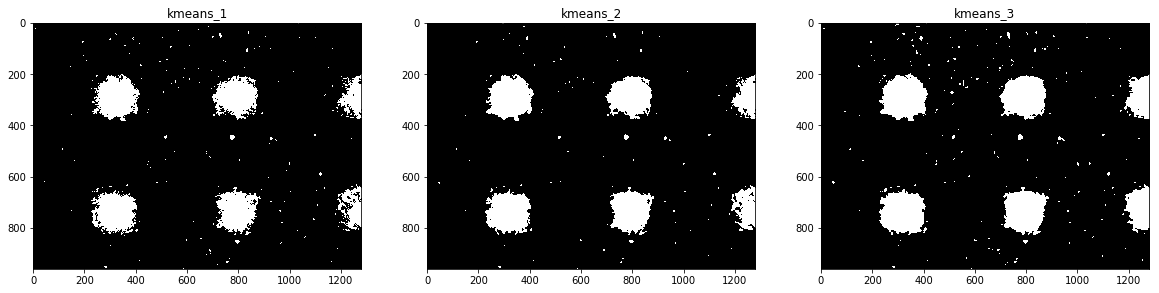

In [17]:
originals_kmeans = compare_methods(pcs(originals[0]))
plot3images(originals_kmeans, ['kmeans_1', 'kmeans_2', 'kmeans_3'])

Tempo de execução kmeans_1 0:00:01.669578 
Tempo de execução kmeans_2 0:00:01.405761 
Tempo de execução kmeans_3 0:00:01.264880 


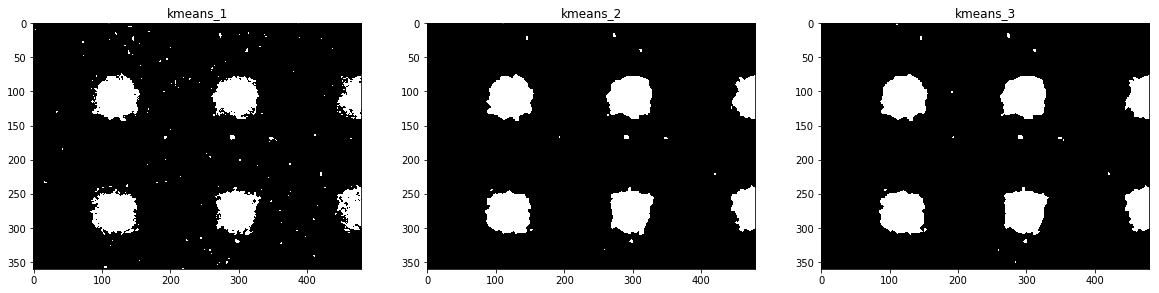

In [18]:
reduced_50_kmeans = compare_methods(pcs(reduced_50[0],0.1))
plot3images(reduced_50_kmeans, ['kmeans_1', 'kmeans_2', 'kmeans_3'])

Tempo de execução kmeans_1 0:00:00.296775 
Tempo de execução kmeans_2 0:00:00.271548 
Tempo de execução kmeans_3 0:00:00.235208 


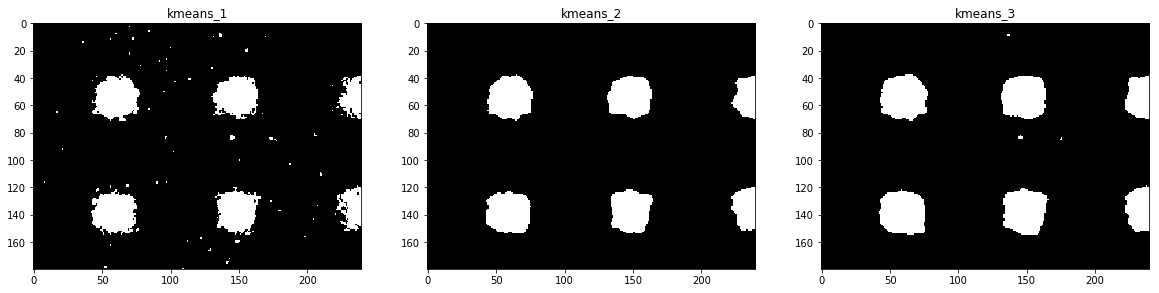

In [21]:
reduced_25_kmeans = compare_methods(pcs(reduced_25[0],0.1))
plot3images(reduced_25_kmeans, ['kmeans_1', 'kmeans_2', 'kmeans_3'])

<h2>Usando KMeans para encontrar os microambientes</h2>

O método que se mostrou mais eficiente foi o KMeans, usando o log_transformation junto com o mediablur como pré-processamento, embora todos tenham tido resultado semelhante, em relação a segmentação, o terceiro foi mais rápido.

Agora para encontrar o microambiente vamos usar o retorno gerado pela segmentação, para criar imagens de cada microambiente individualmente.

Depois disso, comparar se cada grupo de imagem consegue identificar o numero correto de microambientes.

In [22]:
def find_microenvironments(img2print, mask, type_img=1 ):    
    mask = mask.copy()
    img2print = img2print.copy()
    _mask = np.zeros_like(img2print)
    microenvironments = []
    
    
    if type_img == 1:
        area_min = 3000
        count_cnt_min = 100
        plus = 50
        max_r = 200
        text_size = 5
    elif type_img == 2:
        area_min = 1500
        count_cnt_min = 50
        plus = 25
        max_r = 100
        text_size = 2
    elif type_img == 3:
        area_min = 300 
        count_cnt_min = 10
        plus = 12
        max_r = 50
        text_size = 1
        

    _, contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        area = cv2.contourArea(cnt)

        if area < area_min:
            continue

        if len(cnt) < count_cnt_min:
            continue
        '''
        if len(microenvironments) > 0 :
            continue
        '''

        
        _e = list(cv2.fitEllipse(cnt))
        
        #excluindo raios muito grandes
        if(_e[1][0] > max_r or _e[1][1] > max_r):
            continue
        
        #aumentando os raios da elipse para exluir algum erro.
        #print(area, len(cnt), _e[1])
        _e[1] = (_e[1][0] + plus, _e[1][1] + plus)
        ellipse = tuple(_e) 
        
        mask = np.zeros_like(img2print)
        cv2.ellipse(mask, ellipse, (255,255,255), -1)
        masked = np.bitwise_and(img2print, mask)
        microenvironments.append(masked)
        cv2.ellipse(img2print, ellipse, (0,255,0), 4)
        cv2.putText(img2print,
                    str(len(microenvironments) - 1), 
                    (int(ellipse[0][0]) - plus, int(ellipse[0][1])),
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    text_size, 
                    255,
                    2)
        cv2.ellipse(_mask, ellipse, (255,255,255), -1)
        
    
    return (microenvironments, img2print, _mask)

def compare_find_microenvironments(index_original, index_kmeans):
    fig = plt.figure()
    fig.set_size_inches((20,10))
    
    me1, img2print, mask = find_microenvironments(originals[index_original], originals_kmeans[index_kmeans], 1)
    plt.subplot(1,3,1)
    plt.title('Original')
    plt.imshow(img2print, 'gray')
    
    me2, img2print, mask = find_microenvironments(reduced_50[index_original], reduced_50_kmeans[index_kmeans], 2)
    plt.subplot(1,3,2)
    plt.title('Reduzida 50%')
    plt.imshow(img2print, 'gray')
    
    me3, img2print, mask = find_microenvironments(reduced_25[index_original], reduced_25_kmeans[index_kmeans], 3)
    plt.subplot(1,3,3)
    plt.title('Reduzida 25%')
    plt.imshow(img2print, 'gray')
    
    return (me1, me2, me3)
    

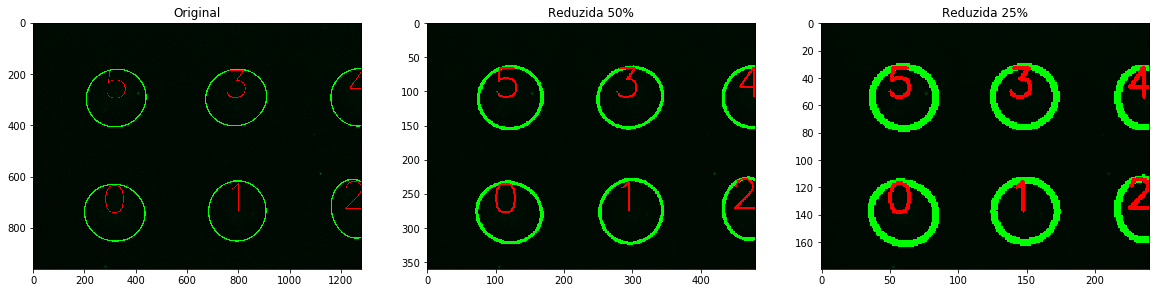

In [102]:
microenvironments = compare_find_microenvironments(1,2)

<h2>Contagem das células mortas</h2>

Como visto acima, os microambientes foram devidamente identificados em todos os grupos de imagem. A partir de agora o trabalho é para identificar em cada microambiente identificado a quantidade de células mortas.

Abaixo, é usado um algoritmo semelhante ao usado para encontrar os microambientes. Foram feitas algumas modificações para contar as células mortas em cada microambiente e no final comparar os resultados.

In [103]:
import pandas as pd
df = pd.DataFrame(columns = ['MICROAMBIENTE', 'me 0', 'me 1', 'me 2','me 3', 'me 4','me 5', 'me 6','me 7', 'me 8','me 9'])


for k, me in enumerate(microenvironments):
    
    nome = 'Original'
    if(k == 1):
        nome = 'Reduzido 50%'
    elif k == 2:
        nome = 'Reduzido 25%'
    
    row = ['{}'.format(nome), '-','-','-','-','-','-','-','-','-','-']
    for i, m in enumerate(me):

        _masked = cv2.cvtColor(m, cv2.COLOR_BGR2GRAY)
        #blur = cv2.medianBlur(_masked,5)
        ret,thresh1 = cv2.threshold(_masked,20,255,cv2.THRESH_TOZERO) #THRESH_TOZERO     THRESH_BINARY
        
        _, contours, hierarchy = cv2.findContours(thresh1, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        cells = 0
        for cnt in contours:
            area = cv2.contourArea(cnt)
            #print(k, cnt.shape)
            if(cnt.shape[0] < 5):
                continue

            #print(k, i)
            ellipse = cv2.fitEllipse(cnt)  
            cv2.ellipse(m, ellipse, (0,255,0), 4)
            #plt.imshow(m)
            cells += 1

        row[i+1] = cells
        #print('{} Microambiente {}; {} células mortas encontradas'.format(k, i, cells))
        
    df.loc[len(df)] = row

0 (3, 1, 2)
0 (9, 1, 2)
0 (1, 1, 2)
0 (1, 1, 2)
0 (19, 1, 2)
1 (1, 1, 2)
1 (4, 1, 2)
1 (1, 1, 2)
1 (6, 1, 2)
2 (1, 1, 2)
2 (4, 1, 2)


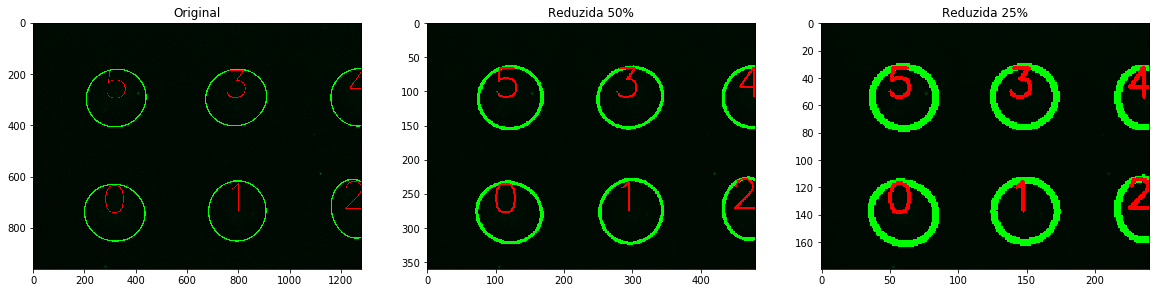

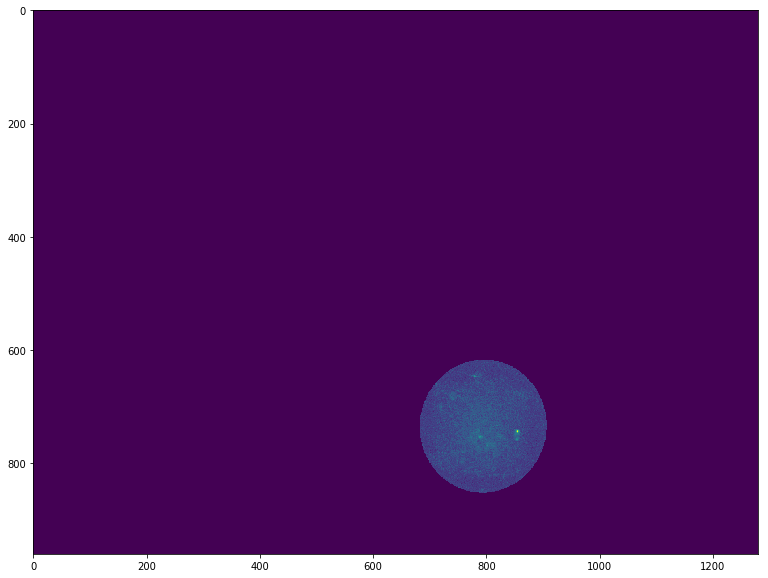

In [98]:
fig = plt.figure()
fig.set_size_inches((20,10))
_masked = cv2.cvtColor(microenvironments[0][1], cv2.COLOR_BGR2GRAY)
#blur = cv2.medianBlur(_masked,5)
ret,thresh1 = cv2.threshold(_masked,20,255,cv2.THRESH_BINARY) #THRESH_TOZERO     THRESH_BINARY
plt.imshow(_masked)

<h2>Resultado</h2>

Temos que na contagem das células mortas, o resultado divergiu entre a imagem original e as imagens reduzidas. Por esse motivo, só será possível usar a imagem original para analisar todas as imagens.

In [99]:
df

,MICROAMBIENTE,me 0,me 1,me 2,me 3,me 4,me 5,me 6,me 7,me 8,me 9
0,Original,0,1,0,0,0,1,-,-,-,-
1,Reduzido 50%,0,0,0,0,0,1,-,-,-,-
2,Reduzido 25%,0,0,0,0,0,0,-,-,-,-


<h2>Fontes</h2>

https://www.researchgate.net/publication/283185016_Image_Segmentation_Using_K_-means_Clustering_Algorithm_and_Subtractive_Clustering_Algorithm

https://docplayer.net/22673363-Colour-image-segmentation-approach-for-detection-of-malaria-parasites-using-various-colour-models-and-k-means-clustering.html

https://docs.opencv.org/3.4.0/d7/d4d/tutorial_py_thresholding.html

https://medium.com/@sonu008/image-enhancement-contrast-stretching-using-opencv-python-6ad61f6f171c

http://www.cs.uregina.ca/Links/class-info/425/Lab3/

https://www.researchgate.net/publication/224227539_Improving_colour_image_segmentation_on_acute_myelogenous_leukaemia_images_using_contrast_enhancement_techniques

http://www.indjst.org/index.php/indjst/article/viewFile/111353/78453

https://www.researchgate.net/publication/263618841_Colour_Image_Segmentation_Using_Unsupervised_Clustering_Technique_for_Acute_Leukemia_Images

http://interscience.in/IJPPT_Vol2Iss1/29-34.pdf